# Использование [ансамблевых моделей](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD)) (или композиции моделей)

Идея использования ансамблевых моделей состоит в том, что оценивается результат совместного голосования различных моделей. Идеи объединения моделей в ансамбль могут быть различными. 

Использование ансамблевых моделей поддерживается в [scikit-learn.](https://scikit-learn.org/stable/modules/ensemble.html)

Рассмотрение данной темы базируется на источнике [Открытый курс машинного обучения. Тема 5. Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Бутстрэп

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $X$ размера $N$. Равномерно возьмем из выборки $N$ объектов с возвращением. Это означает, что мы будем $N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $X_1$. Повторяя процедуру K раз, сгенерируем K подвыборок $X_1$ ... $X_K$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

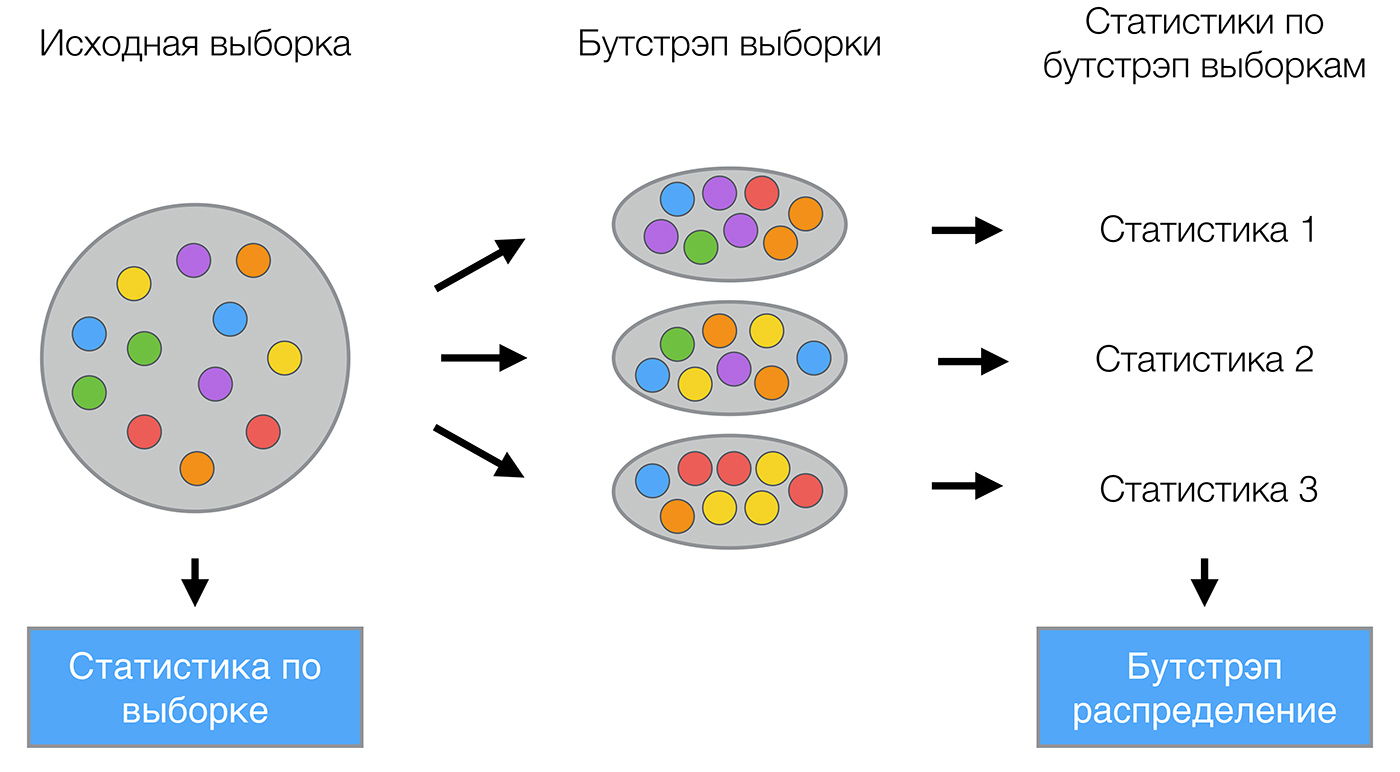

In [2]:
Image("img/bootstrap.jpg")

## Бэггинг

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман Лео Брейманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа.

Пусть имеется обучающая выборка $X$ размера $N$. С помощью бутстрэпа сгенерируем из этой выборки $K$ подвыборок $X_1$ ... $X_K$. Теперь на каждой выборке обучим свою модель $M_i(x)$. Итоговый классификатор будет усреднять ответы всех моделей (выбирать средний результат голосования): $M(x) = \frac{1}{K} \sum\limits_{i=1}^K M_i(x)$

**Важно** то что модель бэггинга строится на ансамбле **разных** обучающих выборок, но **одинаковых** моделей.

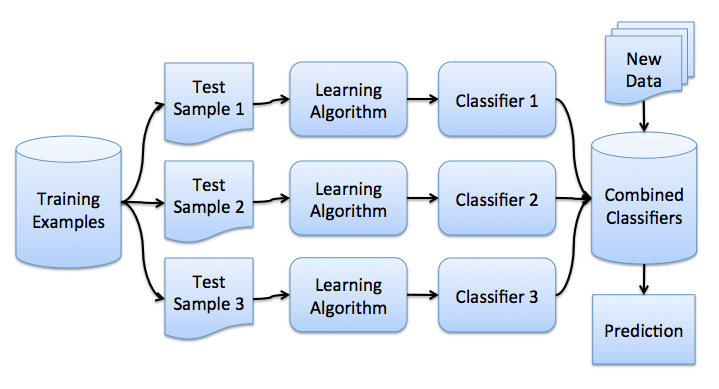

In [3]:
Image("img/bagging.png")

Данный метод реализуется в scikit-learn с помощью классов [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и [BaggingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

In [4]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [5]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

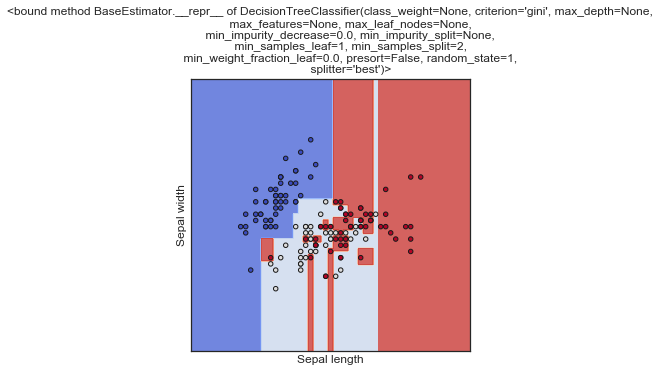

In [6]:
plot_cl(DecisionTreeClassifier(random_state=1))

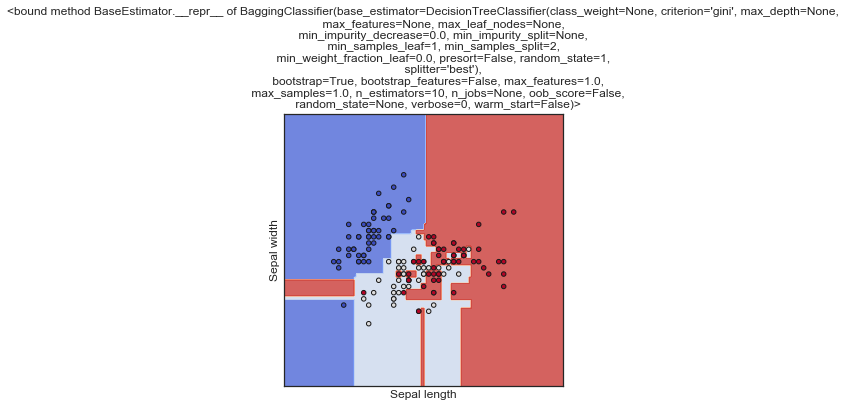

In [7]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1)))

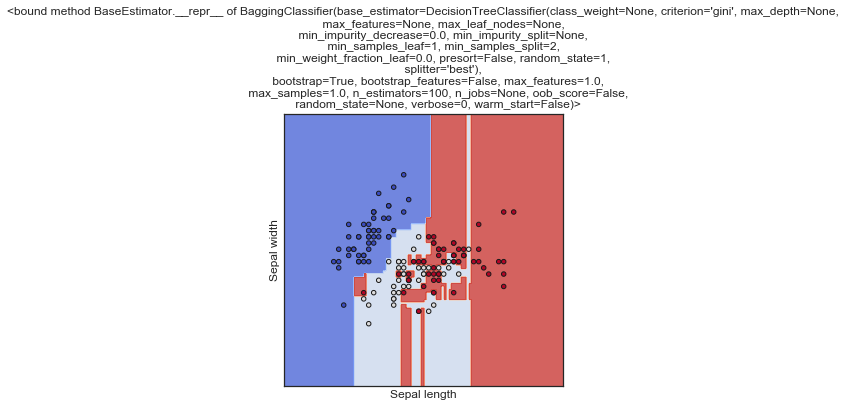

In [8]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

# Дополнительные источники
- [Открытый курс машинного обучения. Тема 5. Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)
- [Блог Александра Дьяконова. Случайный лес (Random Forest)](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)